# Principal Component Analysis, PCA

The most common dimensionality reduction technique out there is without a doubt PCA. Partly because of the speed, but mostly due to the initutive nature of the algorithm. 

PCA simply takes a large data set $X$ with $>>k$ predictors and reduces it to a new data set $Y_k$ with $k$ predictors. It does it through taking out one "principal component" which containst the maximum variance, i.e. information, from $X$. Each consequtive principal component taken out will be orthogonal to all previous ones and slowly reduce $X$ and add to $Y_k$.


## Explained variance
One of the most important features of PCA is that it is very simple to conclude the amount of information kept in the transformation. Moreso, we can get the percent of the information (i.e. variance) in each principal component.

## Note on training
Since the CMA-ES algorthim generates iterations which are normally distributed in each dimension, we make an important decision to **only train on feasible solutions**, and then fit the unfeasible to that transformation. This, as PCA is an unsupervised learning algorthim and if we looked at all at once, we would not find much anything.

## Outline
1. Data import

2. Model Exploration
    1. One iteration at a time.
    2. Over multiple iterations
3. Conclusion

In [1]:
# External
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
# Internal
from utils.import_data import importData
from utils.model_tester import ModelTester
import utils.nicer_plots

In [2]:
# import the data
file_data = "data2.csv"
file_labels = "labels2.csv"
n_features = -1
directory = "\data\\"

data, labels = importData(file_data, file_labels, directory, n_features)

Number of samples:    102400
Number of features:   3851


# Model Exploration

## A. One iteration at a time.
We simply sort out a number of iterations at random and study if there are dimensions containing unnecessary information among in each of them.

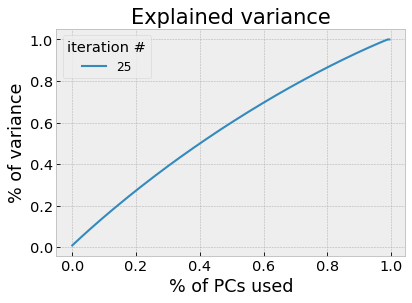

In [3]:
iteration = 25 # looking at the 25th iteration in our data set

# Choosing number of components. can't be more than dimensions, or the number of samples in each iteration
n_components = sum((labels['iteration']==iteration)&(labels['binary-label']==0)) 

# initiate the model
pca = PCA(n_components=n_components) 

# fit feasible solutions of our iteration
principalComponents = pca.fit_transform(data[(labels['iteration']==iteration)&(labels['binary-label']==0)].values)

# plotting the results
fig, ax = plt.subplots()
x_axis=np.arange(0,0.9999,1/n_components)
y_axis=np.cumsum(pca.explained_variance_ratio_)
ax.plot(x_axis,y_axis,label=iteration)

ax.set_xlabel("% of PCs used")
ax.set_ylabel("% of variance")
ax.set_title("Explained variance")
ax.legend(title="iteration #")

plt.show()

Hm, doesn't look great. Ideally, we would want a graphs that is close to the upper left corner => most of the information is kept in the first few components.

Okay so that was just one iteration. Let's take out a few at random and look to see if there is a difference between iterations.

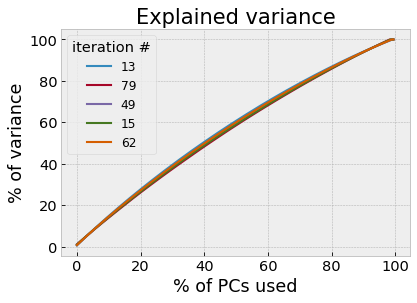

In [4]:
# a out a few iterations by random
iterations =  np.random.choice(list(set(labels['iteration'])), 5) 

fig, ax = plt.subplots()

# automating the shown previously
for iteration in iterations:
    n_components = sum((labels['iteration']==iteration)&(labels['binary-label']==0)) # can't be more than dimensions, or (in this case) the number of samples in each iteration
    pca = PCA(n_components=n_components) 
    principalComponents = pca.fit_transform(data[(labels['iteration']==iteration)&(labels['binary-label']==0)].values)

    x_axis=np.arange(0,0.9999,1/n_components)*100
    y_axis=np.cumsum(pca.explained_variance_ratio_)*100
    ax.plot(x_axis,y_axis,label=iteration)

ax.set_xlabel("% of PCs used")
ax.set_ylabel("% of variance")
ax.set_title("Explained variance")
ax.legend(title="iteration #")

plt.show()

They look pretty similar... So what was shown before, that no dimension could be reduced, seems rebust.

### Comparing to truly gaussian data
To have something to compare our explained variance graphs to, we perform PCA on a gaussian (normally distributed) data set. In theory, you can't reduce information from a gaussian data set. So if our graphs above are close to one truly gaussian distribution, we have more evidence of not being able to reduce the number of dimensions.

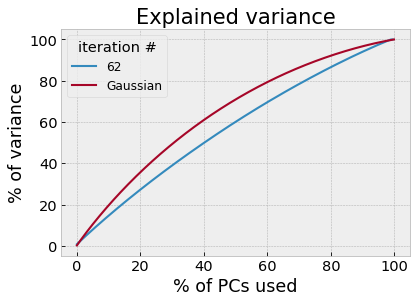

In [5]:
random_data = np.random.random([4000,1000]) # random data, 4k dim, 1000 samples (close to what we have)

pca = PCA(n_components=1000) # n_comp is equal to number of data points
pca.fit(random_data)

# plotting the results
fig, ax = plt.subplots()

ax.plot(x_axis,y_axis,label=iteration) # since we have the last iteration still in memory, we can plot that too.
x_axis=np.arange(0,0.9999,1/1000)*100
y_axis=np.cumsum(pca.explained_variance_ratio_)*100
ax.plot(x_axis,y_axis,label="Gaussian")

ax.set_xlabel("% of PCs used")
ax.set_ylabel("% of variance")
ax.set_title("Explained variance")
ax.legend(title="iteration #")

plt.show()

They fall right on top of one another. Meaning, PCA wasn't able to make any difference between our data set and a truly random set.

## B. PC over multiple iterations

One theory of the failure above is the lack of data to train on. Since we only train on feasible solutions in one iteration, there is only about 200 data points, whilst still 4k dimensions. To combat this. We look to group iterations to see if there is a difference.


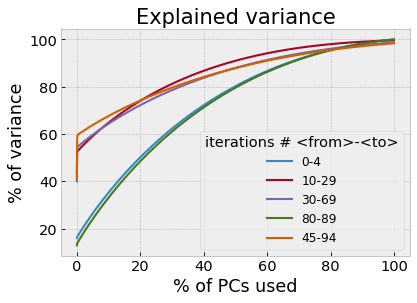

In [6]:
# Generate a few samples of different lengths
iterations =  [np.arange(0,  0+5), # from 0 to 4
               np.arange(10, 10+20), # from 10 to 29
               np.arange(30, 30+40), # from 30 to 69
               np.arange(80, 80+10), # etc
               np.arange(45, 45+50)]
               
fig, ax = plt.subplots()

# calculations similar to before but with multiple iterations at once
for iteration in iterations:
    n_components = min(3096,sum((labels['iteration'].isin(iteration))&(labels['binary-label']==0))) # can't be more than dimensions, or (in this case) the number of samples in each iteration
    pca = PCA(n_components=n_components) 
    principalComponents = pca.fit_transform(data[(labels['iteration'].isin(iteration))&(labels['binary-label']==0)].values)
    principalDf = pd.DataFrame(data = principalComponents
                 , columns = [str('principal component '+str(x)) for x in range(n_components)])
    finalDf = pd.concat([principalDf, labels[['binary-label']]], axis = 1)
    x_axis=np.arange(0,0.9999,1/n_components)*100
    y_axis=np.cumsum(pca.explained_variance_ratio_)*100
    ax.plot(x_axis,y_axis,label=str(iteration[0])+"-"+str(iteration[-1]))

ax.set_xlabel("% of PCs used")
ax.set_ylabel("% of variance")
ax.set_title("Explained variance")
ax.legend(title="iterations # <from>-<to>")

plt.show()

Looks a bit better than before. The first component seems to carry the absolute most information, then it decreases similar to as before. An **important** discovery is however the fact that **training on more itertations => more variance is kept in the first PC**.

This is probably the stepping evolution of CMA-ES that we see. i.e. we have only identified that iterations move.

But to be sure of this, we do it again and plot the first and second component.


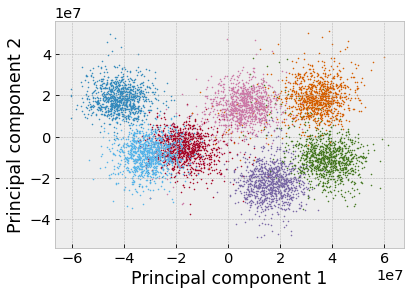

In [8]:
iterations =  np.arange(20, 20+7) # taken "at random"
               
fig, ax = plt.subplots()

n_components = min(3096,sum((labels['iteration'].isin(iterations))&(labels['binary-label']==0))) # can't be more than dimensions, or (in this case) the number of samples in each iteration
pca = PCA(n_components=n_components) 

# this time, we fit the data first 
embedding = pca.fit(data[(labels['iteration'].isin(iterations))&(labels['binary-label']==0)].values)
# to then transfrom the full data set of the iterations we look at.
principalComponents = embedding.transform(data.values)

principalDf = pd.DataFrame(data = principalComponents
             , columns = [str('principal component '+str(x)) for x in range(n_components)])

for iteration in iterations:  
    x_axis = principalDf[labels['iteration']==iteration]['principal component 1']
    y_axis = principalDf[labels['iteration']==iteration]['principal component 2']
    ax.scatter(x_axis,y_axis,label=iteration,s=1)

ax.set_xlabel("Principal component 1")
ax.set_ylabel("Principal component 2")
#ax.set_title("Movement of data across iterations")
#ax.legend(title="iteration #")
plt.show()

We see that iterations exist in clusters, showing that PC1 and PC2 mostly captures the movement and not any information about feasibility. Note that the algorthim moves back-and-forth in our 2D plane, but could be moving in another of the 4k dimensions not caputures by the first and second PC.

# Conclusion

We have shown that this method was **not** able to reduce dimensions in a meaningful way. This is somewhat expected: since the constraints on $\min f(x)$ are likely to be on every dimension on $x$ and unrelated to one another. Thus, all dimensions contain information that is needed.

One could add kernels methods to PCA, i.e. transforming the data and adding higher dimensionality before reducing it. However, with this you lose some of the efficency and understanding which makes PCA interesting to begin with.
